In [10]:
import numpyro
#numpyro.set_platform("cpu")
import jax
import jax.numpy as jnp
import jax.random as jr 
import numpyro.distributions as dist

from numpyro.infer import Predictive, NUTS, MCMC
from numpyro.optim import Adam

import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from utils import sample_training_points_space_filling

from typing import Tuple, List, Callable
import sys
sys.path.append("../")

sns.set_theme("paper", font_scale=1.5)

In [3]:
data = jnp.load('oscilator1_data.npy', allow_pickle=True).item()
X, Y, Y_f = data['X'], data['Y'], data['Y_f']

/opt/homebrew/anaconda3/envs/numpyro_env/lib/python3.12/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


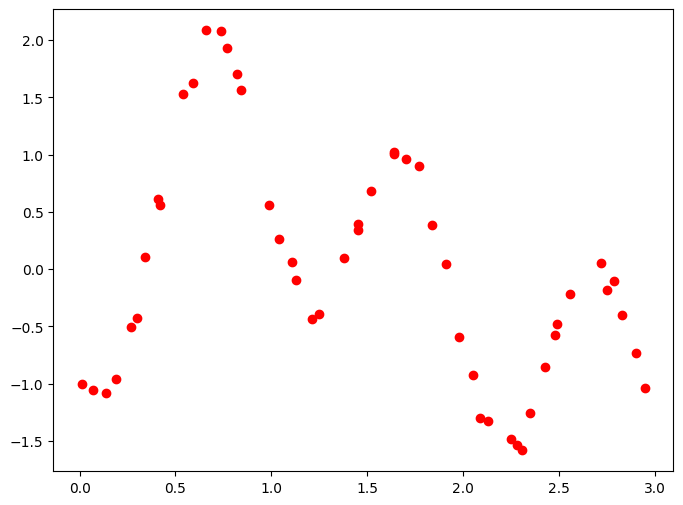

In [4]:
# Sample training points
X_train, Y_train,X_f_samples, Y_f_samples, X_test, Y_1_test, Y_2_test = sample_training_points_space_filling(X, Y, Y_f, 50, seed=0)
#normalize the training data
mean_y = jnp.mean(Y_train)
std_y = jnp.std(Y_train)
Y_train = (Y_train - mean_y) / std_y


# Plot the sampled training points
plt.figure(figsize=(8, 6))

plt.plot(X_train, Y_train, 'ro', label='Y samples')
#plt.plot(X, Y_f, 'g', label='Y_f')
#plt.plot(X_f_samples, Y_f_samples, 'go', label='Y_f samples')
#plt.legend()



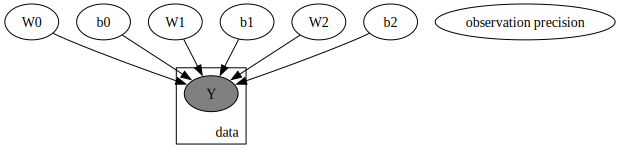

In [5]:
def dense_layer(
        i: int,
        size: List[int],
):  
    #Xavier initialization
    alpha_sq = 2/(size[0] + size[1])
    #alpha_sq = 1.0
    W = numpyro.sample(f"W{i}", dist.Normal(0, alpha_sq**0.5).expand(size))
    b = numpyro.sample(f"b{i}", dist.Normal(0, alpha_sq**0.5).expand((size[-1],)))
    return W, b

def forward(
        W: List[jax.Array],
        b: List[jax.Array],
        X: jax.Array,
        activation: Callable,
):
    #input layer
    z = activation(jnp.dot(X, W[0]) + b[0])

    #hidden layers
    for i in range(1, len(W) - 1):
        z = activation(jnp.dot(z, W[i]) + b[i])

    #output layer with no activation
    z = jnp.dot(z, W[-1]) + b[-1]
    return z.squeeze()


def bnn_model(
        X: jax.Array,
        Y: jax.Array,
        layers: List[int],
):
    N, input_dim = X.shape
    activation = jnp.tanh
    W = []
    b = []
    #build the layers with the given list
    for i, layer in enumerate(layers):
        W_, b_ = dense_layer(i, [input_dim, layer])
        W.append(W_)
        b.append(b_)
        input_dim = layer
    #forward pass through the network
    z = forward(W, b, X, activation)[:, None]

    if Y is not None:
        assert Y.shape == z.shape , f"Y shape {Y.shape} does not match z shape {z.shape}"

    precision_obs = numpyro.sample(r"observation precision", dist.Gamma(2., 1.))
    sigma_obs = 1.0 / jnp.sqrt(precision_obs)   
    sigma_obs = 0.1
    with numpyro.plate("data", N):
        numpyro.sample(
            "Y", 
            dist.Normal(z, sigma_obs).to_event(1), 
            obs=Y
        )

LAYERS = [60, 60, 1]

try:
    render = numpyro.render_model(bnn_model, (X_train, Y_train, LAYERS))
except:
    render = None
    print("Module not installed. (pip install graphviz), (sudo apt-get install graphviz)")
render

In [6]:

inf_key = jax.random.PRNGKey(0)
mcmc = MCMC(NUTS(bnn_model), num_warmup=1000, num_samples=1000)
mcmc.run(inf_key, X_train, Y_train, LAYERS)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [01:10<00:00, 28.20it/s, 511 steps of size 1.07e-02. acc. prob=0.89]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
                W0[0,0]      0.01      0.39      0.03     -0.57      0.57    269.81      1.00
                W0[0,1]      0.01      0.39      0.03     -0.60      0.56    392.03      1.00
                W0[0,2]     -0.03      0.40     -0.07     -0.61      0.56    329.30      1.00
                W0[0,3]      0.00      0.41      0.02     -0.61      0.58    392.06      1.01
                W0[0,4]     -0.01      0.39      0.01     -0.60      0.57    372.87      1.00
                W0[0,5]     -0.01      0.41     -0.01     -0.59      0.60    356.41      1.00
                W0[0,6]     -0.02      0.39     -0.06     -0.61      0.54    208.10      1.00
                W0[0,7]      0.01      0.39      0.05     -0.59      0.56    312.85      1.00
                W0[0,8]     -0.02      0.40     -0.04     -0.67      0.54    488.36      1.01
                W0[0,9]      0.04      0.40      0.07     -

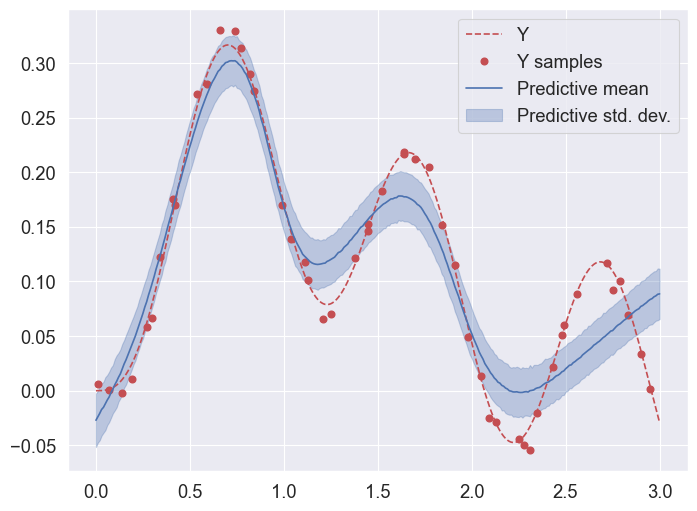

In [17]:
#predictive
predictive = Predictive(bnn_model, samples, return_sites=["Y"])
predictions = predictive(jax.random.PRNGKey(1), X_test, None, LAYERS) 

# Plot the sampled training points
plt.figure(figsize=(8, 6))
plt.plot(X, Y, 'r--', label='Y')
plt.plot(X_train, Y_train*std_y + mean_y, 'ro', label='Y samples')

# Plot the predictions
mean_prediction = jnp.mean(predictions["Y"], axis=0)
stddev_prediction = jnp.std(predictions["Y"], axis=0)
plt.plot(X_test, mean_prediction*std_y + mean_y, 'b', label='Predictive mean')
plt.fill_between(
    X_test.flatten(),
    (mean_prediction - 2 * stddev_prediction).flatten()*std_y + mean_y,
    (mean_prediction + 2 * stddev_prediction).flatten()*std_y + mean_y,
    color='b',
    alpha=0.3,
    label="Predictive std. dev.",
)
plt.legend()
plt.savefig("../plots/bnn_oscilator1.png", dpi=300)
#plot gamma distribution

